## Transfer Learning with TensorFlow Part1: Feature Extraction


Transfer learning  is leverageing a working model's exisiting architecture and learned patterns for our own problem.

There are two mani benefits:

1. Can leverage an exisitng neural network architecture proven to work on problems similar to our own

2. Can leverage a working neural network architecture which has already on similar data to our own, then we can adapt those patterns to our own data



In [ ]:
# Are we using GPU?

!nvidia-smi

Mon Feb 14 07:53:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and become one with data



In [ ]:
# Get data (10% of 10 food classes from Food101)

import zipfile

# Download the data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-14 07:55:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   245MB/s    in 0.7s    

2022-02-14 07:55:47 (245 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?

import os

# Walk through 10 percent data directory and list number of files

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

There are 2 directories and 0 images in '10_food_classes_10_percent' .
There are 10 directories and 0 images in '10_food_classes_10_percent/test' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger' .
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi' .
There are 0 directories and 250 images in '10_food_classes_10_perce

## Creating data loaders (perparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images:")

test_data= test_datagen.flow_from_directory(test_dir,
                                            target_size = IMAGE_SHAPE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra funtionality we can add to models to be performed during after training.
Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (funtionized because we need to create a new one for each time)

import datetime

def create_tensorboard_callback(dir_name,experiment_name):

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")

  return tensorboard_callback
  

## Creating models using TensorFlow Hub

We've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on : https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies

import tensorflow as tf

import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and sve it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,# freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,)) 
  # Create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation = "softmax", name = "output_layer")
  ])
  return model

### Creating ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model

resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")],
                                  validation_steps = len(test_data))

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20220214-085459
Epoch 1/5
24/24 [==============================] - 32s 769ms/step - loss: 1.8582 - accuracy: 0.3880 - val_loss: 1.2416 - val_accuracy: 0.6028
Epoch 2/5
24/24 [==============================] - 16s 673ms/step - loss: 0.9000 - accuracy: 0.7227 - val_loss: 0.8537 - val_accuracy: 0.7292
Epoch 3/5
24/24 [==============================] - 16s 684ms/step - loss: 0.5991 - accuracy: 0.8373 - val_loss: 0.7580 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 16s 669ms/step - loss: 0.4579 - accuracy: 0.8907 - val_loss: 0.7049 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 15s 662ms/step - loss: 0.3700 - accuracy: 0.9173 - val_loss: 0.6771 - val_accuracy: 0.7756


Our transfer learning feature extractor model out performed modles we built by hand... (substantially) and in a quicker traning time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves
# Tidbit : we could put a function like called helper.py 

import matplotlib.pyplot as plt

# Plot the validation and training curves

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns: 
    Plots of training/validation loss and accuracy metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy,label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("Epochs")
  plt.legend()

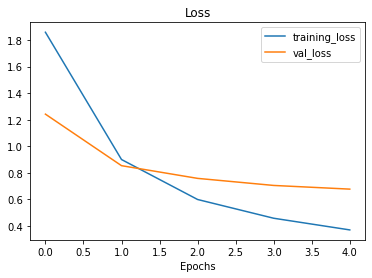

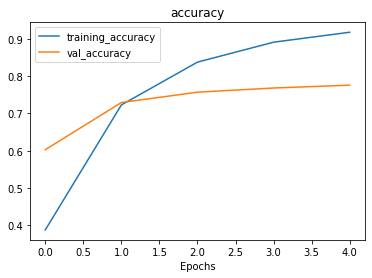

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model

efficient_model = create_model(model_url = efficient_url,
                               num_classes =train_data_10_percent.num_classes)

efficient_model.compile(loss = "categorical_crossentropy",
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

efficient_history = efficient_model.fit(train_data_10_percent,
                                        epochs = 5,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                 experiment_name = "efficientnetb0")] )


Saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20220214-092328
Epoch 1/5
24/24 [==============================] - 25s 708ms/step - loss: 1.8862 - accuracy: 0.4093 - val_loss: 1.3165 - val_accuracy: 0.7332
Epoch 2/5
24/24 [==============================] - 15s 645ms/step - loss: 1.0658 - accuracy: 0.7920 - val_loss: 0.8679 - val_accuracy: 0.8216
Epoch 3/5
24/24 [==============================] - 15s 644ms/step - loss: 0.7509 - accuracy: 0.8440 - val_loss: 0.6967 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 16s 672ms/step - loss: 0.6036 - accuracy: 0.8747 - val_loss: 0.6111 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 15s 643ms/step - loss: 0.5069 - accuracy: 0.9000 - val_loss: 0.5578 - val_accuracy: 0.8616


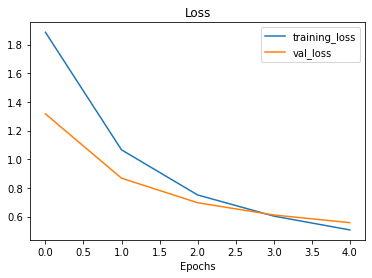

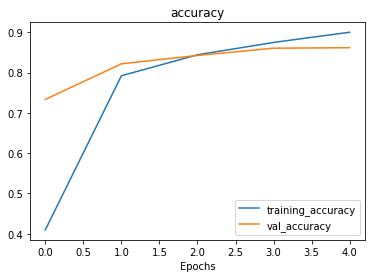

In [ ]:
plot_loss_curves(efficient_history)

In [ ]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does efficientb0 feature extracotr have?
len(efficient_model.layers[0].weights)

309

## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes what so ever (e.g. using ImageNet model on ImageNet c )
* "Feature extraction" transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for problem (e.g. 1000 classes -> 10 classes of food)
* "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)



## Comparing our models results using TensorBoard

> **Note:** When we upload things to TensorBoard.dev, our experiments are public. So if we are running private experiments (things we don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architecture using 10% of the trainig data" \
  --one_shot 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=0VE074U8Sms5Wow7CCGjGX0M2Sbiti&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publicaaly here https://tensorboard.dev/experiment/mhEdvYGLRKK5qz5xTlQEXA/

In [ ]:
# Check out what TensorBoard experiments we have
!tensorboard dev list

https://tensorboard.dev/experiment/mhEdvYGLRKK5qz5xTlQEXA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the trainig data
	Id                   mhEdvYGLRKK5qz5xTlQEXA
	Created              2022-02-14 09:46:29 (3 minutes ago)
	Updated              2022-02-14 09:46:31 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5795363
Total: 1 experiment(s)


Delete an experiment   
!tensorboard dev delete --experiment_id mhEdvYGLRKK5qz5xTlQEXA

